# Contents
    1)Created our own CNN model with image sizes 112x112:
        -Included ImageDataGenerator but did not use Data Augmentation
        -we have Callbacks with earlystopping,checkpoints and cvs log
        -Stopped too early because I set patience to be 3, however unable to train again because the computations is too time consuming
        -validation accuracy seem to be about %50 which is quite low
    2)Fine-tuned VGG16 with the hopes of inreasing accuracy - with image size 224x224
        -preprocessed the images specically for vgg16
        -dropped final layer of vgg16 and added a dense layer of 100 and a final layer of 450 after
        -training time is still way to long which is why I tried to train it with only steps_per_epoch=100 as opposed to batch size of 2208
        -still taking forever to calculate 
    
# Things to do
    - Get a computer with GPU...
    - or impliment on a cloud computing server such as EC2?
    - If committed then certainly increase steps_per_epoch for VGG16
    - Consider if we need to unfreeze some convolutional layers in VGG16
    

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
sns.set_style('darkgrid')

In [5]:
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import tensorflow as tf

#### 1. Load and prepare the data

In [3]:
import os
import shutil

In [4]:
os.getcwd()

'C:\\Users\\rmzny\\Desktop\\Project Birdy'

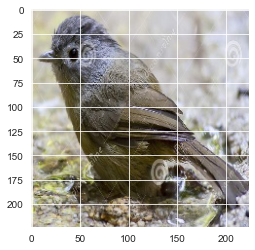

In [5]:
# lets see how the data looks
image = mpimg.imread("C:\\Users\\rmzny\\Desktop\\Project Birdy\\train\\ABBOTTS BABBLER\\001.jpg")
plt.imshow(image)
plt.show()

In [6]:
#it is originally 224x224 but but we may reduce by half to reduce computation time.
image_size=(112,112)

test_path='C:\\Users\\rmzny\\Desktop\\Project Birdy\\test'
test_datagen=ImageDataGenerator(rescale=1./255)
test_batches = test_datagen.flow_from_directory(
        test_path,
        target_size=image_size,
        color_mode='rgb',
        batch_size=32,
        class_mode='categorical',
        shuffle=False, #we dont shuffle because 1:14:05
        seed=101)

train_path='C:\\Users\\rmzny\\Desktop\\Project Birdy\\train'
train_datagen=ImageDataGenerator(rescale=1./255)
train_batches = train_datagen.flow_from_directory(
        train_path,
        target_size=image_size,
        color_mode='rgb',
        batch_size=32,
        class_mode='categorical',
        shuffle=True,
        seed=101)

valid_path='C:\\Users\\rmzny\\Desktop\\Project Birdy\\valid'
valid_datagen=ImageDataGenerator(rescale=1./255)
valid_batches = valid_datagen.flow_from_directory(
        valid_path,
        target_size=image_size,
        color_mode='rgb',
        batch_size=32,
        class_mode='categorical',
        shuffle=True,
        seed=101)



Found 2250 images belonging to 450 classes.
Found 70626 images belonging to 450 classes.
Found 2250 images belonging to 450 classes.


##### Now we have batches here, for instance train_datagenerator is an iterator of tuples (representing each bach) (x,y) 
where x is a numpy array of containing a batch of images with dimensions (batch_size,targetsize,channels=3 because it is colored i.e. rbg image)
where y is a numpy array of corresponding labels, in our case since we have 450 classes it should be batch size by 450

In [7]:
#as an example
print('batch tuple',type(train_batches[0]),len(train_batches[0]))
print('batch size,image size of an image',train_batches[0][0].shape)
print('\n')
print('classes in the 0th batch',train_batches[0][1].shape)

batch tuple <class 'tuple'> 2
batch size,image size of an image (32, 112, 112, 3)


classes in the 0th batch (32, 450)


In [8]:
##### lets look at the first images

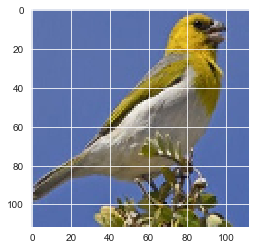

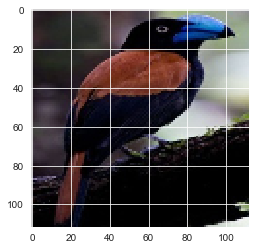

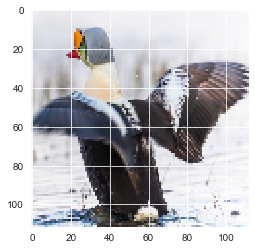

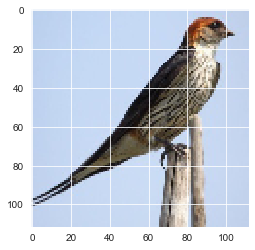

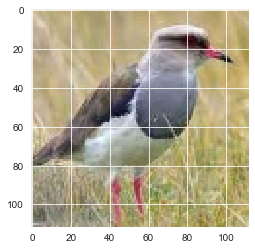

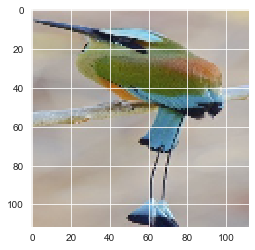

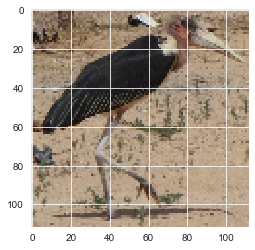

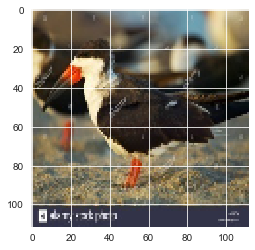

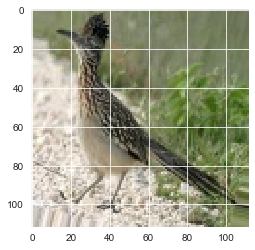

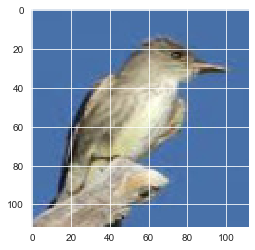

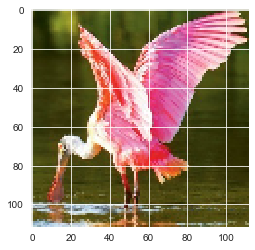

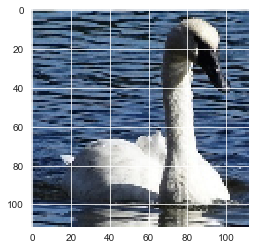

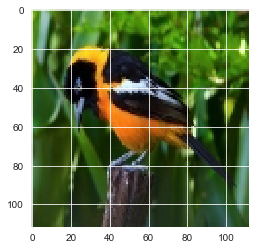

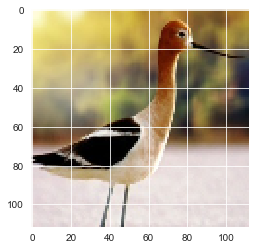

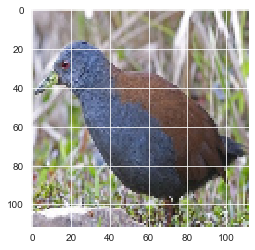

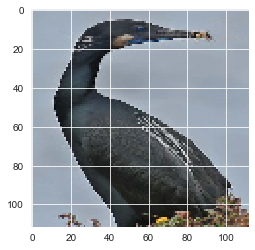

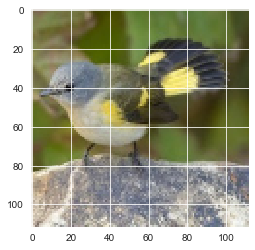

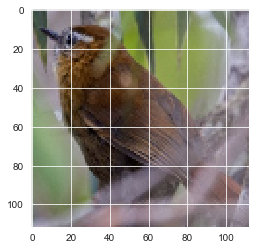

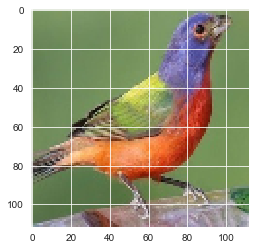

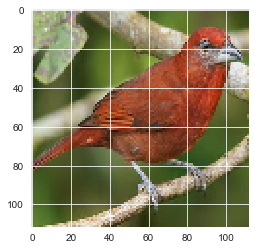

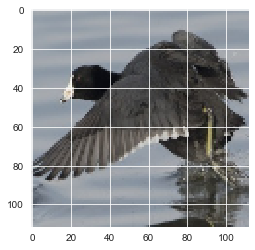

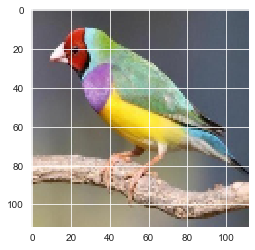

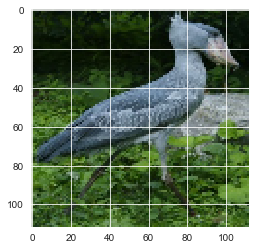

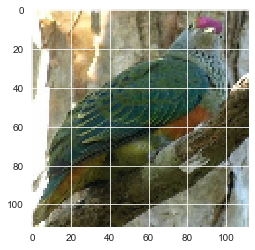

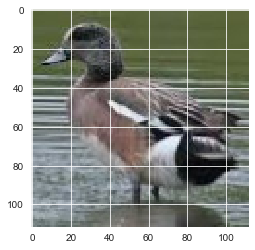

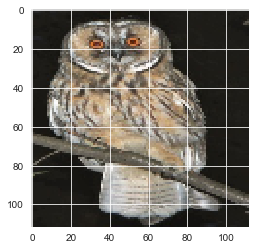

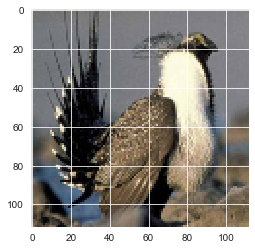

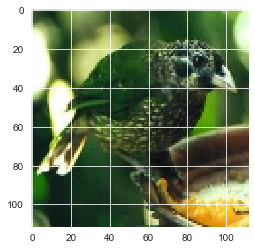

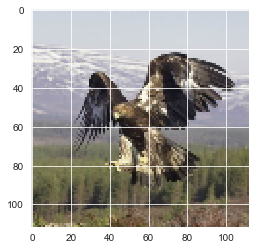

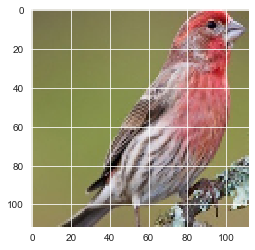

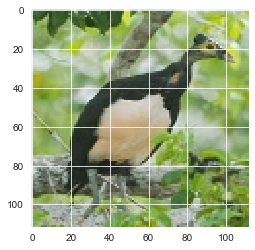

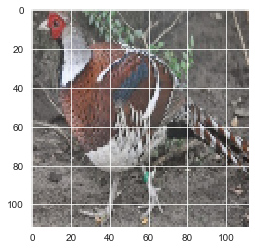

In [9]:
for i in range(len(train_batches[0][0])): 
    plt.imshow(train_batches[0][0][i], interpolation='nearest')
    plt.show()

## Baseline  Model

In [11]:
## Make an empty sequential model
base_model = models.Sequential()

## Add the convolutional layer here
base_model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(112,112,3)))

base_model.add(layers.MaxPooling2D((2,2), strides=2))

base_model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))

base_model.add(layers.MaxPooling2D((2,2), strides=2))

base_model.add(layers.Flatten())

base_model.add(layers.Dense(100, activation='relu'))

base_model.add(layers.Dense(450, activation='softmax'))


In [12]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 100)               5

In [13]:
base_model.compile(optimizer = 'rmsprop',
                 loss = 'categorical_crossentropy',
                 metrics = ['accuracy'])

In [14]:
# We check validation loss if, it does not get better in 3 epoches it stops
early_stop = EarlyStopping(monitor='val_loss',patience=3, verbose=1)

#we save the best trained algorthim
file_path='C:\\Users\\rmzny\\Desktop\\Project Birdy\\saved_models\\weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpoint=ModelCheckpoint(file_path,monitor='val_accuracy',verbose=1,save_best_only=True)

#we keep a nice track as a csv
log_csv=CSVLogger('my_logs.csv',separator=',',append=False)

callback_list=[early_stop,checkpoint,log_csv]

In [15]:
n_epochs=30
base_history = base_model.fit_generator(train_batches,
                                        epochs=n_epochs,
                                        #steps_per_epoch=100,
                                        validation_data=valid_batches,
                                        #validation_steps=50,
                                        callbacks=callback_list)
#callbacks=[callback]) 
base_history= base_history.history

Epoch 1/30


C:\Users\rmzny\AppData\Local\Temp\ipykernel_2224\3644323205.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  base_history = base_model.fit_generator(train_batches,


2208/2208 [==============================] - ETA: 0s - loss: 4.4230 - accuracy: 0.1529
Epoch 1: val_accuracy improved from -inf to 0.34000, saving model to C:\Users\rmzny\Desktop\Project Birdy\saved_models\weights-improvement-01-0.34.hdf5
2208/2208 [==============================] - 835s 378ms/step - loss: 4.4230 - accuracy: 0.1529 - val_loss: 3.0282 - val_accuracy: 0.3400
Epoch 2/30
2208/2208 [==============================] - ETA: 0s - loss: 2.8606 - accuracy: 0.3814
Epoch 2: val_accuracy improved from 0.34000 to 0.44044, saving model to C:\Users\rmzny\Desktop\Project Birdy\saved_models\weights-improvement-02-0.44.hdf5
2208/2208 [==============================] - 833s 377ms/step - loss: 2.8606 - accuracy: 0.3814 - val_loss: 2.5190 - val_accuracy: 0.4404
Epoch 3/30
2208/2208 [==============================] - ETA: 0s - loss: 2.2216 - accuracy: 0.5000
Epoch 3: val_accuracy improved from 0.44044 to 0.47822, saving model to C:\Users\rmzny\Desktop\Project Birdy\saved_models\weights-improv

In [4]:
logs=pd.read_csv('C:\\Users\\rmzny\\Desktop\\Project Birdy\\my_logs.csv')

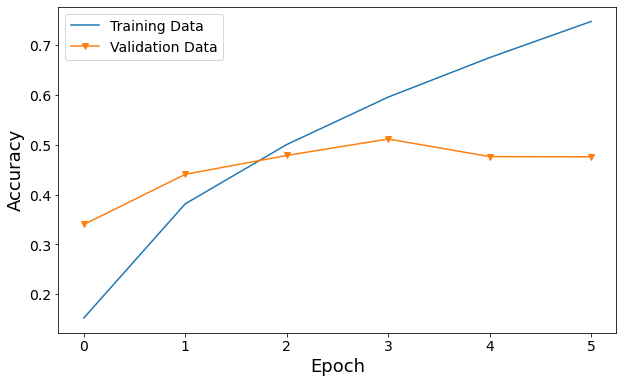

In [13]:
n_epochs=5
plt.figure(figsize=(10,6))
plt.plot(range(n_epochs+1), 
            logs['accuracy'], 
            label="Training Data")
plt.plot(range(n_epochs+1), 
            logs['val_accuracy'], 
            marker='v',
            label="Validation Data")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)


plt.show()

### We can try to improve the sizes of epoches and change the earlystop patience but I wonder if it is work training further considering the amount it takes
    Thus we take another approach and try to fine tune a pretrained model VGG16
    to do so we first need to preprocess images differently, namely we will preprocess like how  they did for VGG16
    Additionally we will use 224x224 images here for 2 reasons
        1) in the original paper they use 224x224
        2) since we will freeze most of the parameters and just train the final dense layers, training time should not be excessively long 

## Experiment with VGG16 

### Preprocesses and import the Data

In [6]:
#it is originally 224x224 but but we may reduce by half to reduce computation time.
image_size=(224,224)

test_path='C:\\Users\\rmzny\\Desktop\\Project Birdy\\test'
test_datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
test_batches = test_datagen.flow_from_directory(
        test_path,
        target_size=image_size,
        color_mode='rgb',
        batch_size=32,
        class_mode='categorical',
        shuffle=False, #we dont shuffle because 1:14:05
        seed=101)

train_path='C:\\Users\\rmzny\\Desktop\\Project Birdy\\train'
train_datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
train_batches = train_datagen.flow_from_directory(
        train_path,
        target_size=image_size,
        color_mode='rgb',
        batch_size=32,
        class_mode='categorical',
        shuffle=True,
        seed=101)

valid_path='C:\\Users\\rmzny\\Desktop\\Project Birdy\\valid'
valid_datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
valid_batches = valid_datagen.flow_from_directory(
        valid_path,
        target_size=image_size,
        color_mode='rgb',
        batch_size=32,
        class_mode='categorical',
        shuffle=True,
        seed=101)



Found 2250 images belonging to 450 classes.
Found 70626 images belonging to 450 classes.
Found 2250 images belonging to 450 classes.


#### How do they look?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


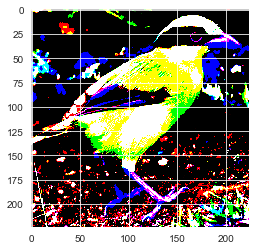

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


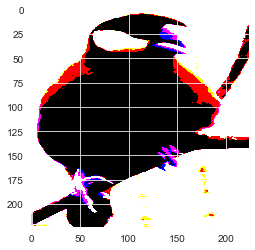

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


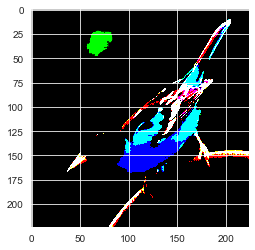

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


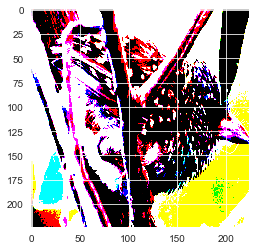

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


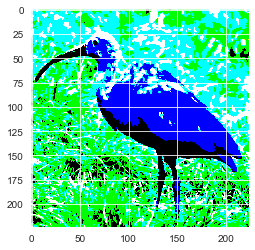

In [15]:
for i in range(5): 
    plt.imshow(train_batches[0][0][i], interpolation='nearest')
    plt.show()

### Import VGG16

In [7]:
vgg16_model=tf.keras.applications.vgg16.VGG16()

In [8]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Creat our own model with fine tuning VGG16

In [9]:
model=models.Sequential()

#Adding every layer of vgg16 except the output -- because we are not predicting 1000 different classes
for layer in vgg16_model.layers[:-1]:
    model.add(layer)
    #freezing these layers
    layer.trainable=False
    
## Adding a dense of 100 and a 450 nodes final layer
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(450, activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

### We will also switch to Adam optimizer

In [11]:
model.compile(optimizer = 'adam',
                 loss = 'categorical_crossentropy',
                 metrics = ['accuracy'])

In [12]:
# We check validation loss if, it does not get better in 10 epoches it stops
early_stop = EarlyStopping(monitor='val_loss',patience=10, verbose=1)

#we save the best trained algorthim
file_path='C:\\Users\\rmzny\\Desktop\\Project Birdy\\saved_models\\vgg16-weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpoint=ModelCheckpoint(file_path,monitor='val_accuracy',verbose=1,save_best_only=True)

#we keep a nice track as a csv
log_csv=CSVLogger('vgg16_logs.csv',separator=',',append=False)

callback_list=[early_stop,checkpoint,log_csv]

In [14]:
n_epochs=50
vgg16_history =model.fit_generator(train_batches,
                                        epochs=n_epochs,
                                        steps_per_epoch=100,
                                        validation_data=valid_batches,
                                        validation_steps=50,
                                        callbacks=callback_list)
#callbacks=[callback]) 
vgg16_history= history.history

Epoch 1/50


C:\Users\rmzny\AppData\Local\Temp\ipykernel_14916\461266513.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vgg16_history =model.fit_generator(train_batches,


100/100 [==============================] - ETA: 0s - loss: 5.5560 - accuracy: 0.0613
Epoch 1: val_accuracy improved from -inf to 0.17250, saving model to C:\Users\rmzny\Desktop\Project Birdy\saved_models\vgg16-weights-improvement-01-0.17.hdf5
100/100 [==============================] - 1268s 13s/step - loss: 5.5560 - accuracy: 0.0613 - val_loss: 4.4249 - val_accuracy: 0.1725
Epoch 2/50
 30/100 [========>.....................] - ETA: 9:55 - loss: 4.1627 - accuracy: 0.1948 


KeyboardInterrupt



In [ ]:
plt.figure(figsize=(10,6))

plt.scatter(range(1,n_epochs+1), 
            vgg16_history['accuracy'], 
            label="Training Data")
plt.scatter(range(1,n_epochs+1), 
            vgg16_history['val_accuracy'], 
            marker='v',
            label="Validation Data")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)


plt.show()